**https://medium.com/nerd-for-tech/fine-tuning-pretrained-bert-for-sentiment-classification-using-transformers-in-python-931ed142e37t**

In [ ]:
!pip install transformers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/complaint_data.csv')
df = df.set_index(df.columns[0])
df.head()


,complaint_what_happened,Topic
Unnamed: 0,,
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,1
10,chase card was reported on xx xx 2019 however...,3
11,on xx xx 2018 while trying to book a xxxx xx...,3
14,my grand son give me check for 1600 00 i de...,0


In [3]:
sentences = df['complaint_what_happened'].tolist()
labels = df['Topic'].tolist()

In [4]:
test = pd.DataFrame({
    'complaints': [
        "I can not get from chase who services my mortgage, who owns it and who has original loan docs",
        "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
        "I want to open a salary account at your downtown branch. Please provide me the procedure.",
        "Yesterday, I received a fraudulent email regarding renewal of my services.",
        "What is the procedure to know my CIBIL score?",
        "I need to know the number of bank branches and their locations in the city of Dubai"
    ],
    'labels':[2,1,0,4,0,0]
})

In [5]:
test

,complaints,labels
0,I can not get from chase who services my mortg...,2
1,The bill amount of my credit card was debited ...,1
2,I want to open a salary account at your downto...,0
3,"Yesterday, I received a fraudulent email regar...",4
4,What is the procedure to know my CIBIL score?,0
5,I need to know the number of bank branches and...,0


In [6]:
test_texts = test['complaints'].values.tolist()

In [7]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(sentences, labels, test_size=.2,random_state=42,stratify=labels)

In [8]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments

In [9]:
model_name  = 'distilbert-base-uncased'

In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=5)

In [11]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True,return_tensors = 'pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')

In [12]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
## Test Dataset
class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

In [13]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentTestDataset(test_encodings)

In [14]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    #recall = recall_score(y_true=labels, y_pred=pred)
    #precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy": accuracy,"f1_score":f1}

In [ ]:
!pip install accelerate>=0.21.0

In [ ]:
!pip install transformers[torch]

In [15]:
training_args = TrainingArguments(
    output_dir='./res',          # output directory
    evaluation_strategy="steps",
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs4',            # directory for storing logs
    #logging_steps=10,
    load_best_model_at_end=True,
)

In [16]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=5)

trainer = Trainer(
    model=model,# the instantiated 🤗 Transformers model to be trained
    args=training_args, # training arguments, defined above
    train_dataset=train_dataset,# training dataset
    eval_dataset=val_dataset , # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.706900,0.293179,0.891815,0.891679
1000,0.261200,0.262496,0.906524,0.906258
1500,0.163000,0.306255,0.902966,0.902720
2000,0.097400,0.281110,0.920996,0.920973
2500,0.047300,0.336358,0.919573,0.919342


TrainOutput(global_step=2635, training_loss=0.24418509228179758, metrics={'train_runtime': 4216.3449, 'train_samples_per_second': 19.99, 'train_steps_per_second': 0.625, 'total_flos': 1.11656120322816e+16, 'train_loss': 0.24418509228179758, 'epoch': 5.0})

In [17]:
trainer.evaluate()

{'eval_loss': 0.2624961733818054,
 'eval_accuracy': 0.9065243179122182,
 'eval_f1_score': 0.9062577319683326,
 'eval_runtime': 69.9531,
 'eval_samples_per_second': 60.255,
 'eval_steps_per_second': 0.943,
 'epoch': 5.0}

In [18]:
test_label = test['labels'].values.tolist()

In [22]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')
test_dataset = SentimentDataset(test_encodings, test_label)
preds = trainer.predict(test_dataset=test_dataset )

In [23]:
probs = torch.from_numpy(preds[0]).softmax(1)

predictions = probs.numpy()# convert tensors to numpy array

In [24]:
newdf = pd.DataFrame(predictions,columns=['Account_Services','Others','Mortgage/Loan','Credit card or prepaid card','Theft/Dispute Reporting'])
newdf.head()

,Account_Services,Others,Mortgage/Loan,Credit card or prepaid card,Theft/Dispute Reporting
0,0.000832,0.000475,0.996871,0.000974,0.000847
1,0.000758,0.992179,0.000380,0.005469,0.001214
2,0.984026,0.003422,0.003329,0.005595,0.003628
3,0.029483,0.019977,0.013071,0.022676,0.914794
4,0.224001,0.104025,0.205154,0.253695,0.213125


In [29]:
def labels(x):
  if x == 0:
    return 'Account Services'
  elif x == 1:
    return 'Others'
  elif x == 2:
    return 'Mortgage/Loan'
  elif x == 3:
    return 'Credit card or prepaid card'
  else:
    return 'Theft/Dispute Reporting'

results = np.argmax(predictions,axis=1)
test['complaints'] = results
test['complaints'] = test['complaints'].map(labels)
test

,complaints,labels
0,Mortgage/Loan,2
1,Others,1
2,Account Services,0
3,Theft/Dispute Reporting,4
4,Credit card or prepaid card,0
5,Account Services,0


<Axes: xlabel='complaints', ylabel='count'>

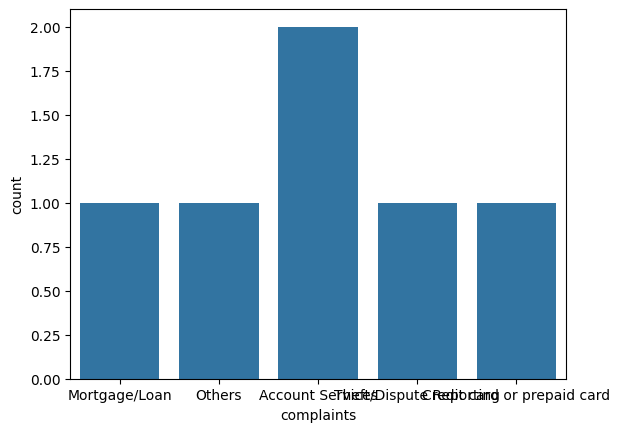

In [26]:
import seaborn as sns
sns.countplot(x='complaints',data=test)

In [28]:
# prompt: i want to save this fine tuned model

trainer.save_model('distilbert_model')
